In [0]:
#Using a python wrapper to obtain dataset
from sodapy import Socrata
import calendar
import json
import pandas as pd
from collections import defaultdict
import string

In [0]:
data_source = "data.sfgov.org"
client = Socrata(data_source, None)

In [0]:
#MORE_INFO: https://dev.socrata.com/foundry/data.sfgov.org/5m6g-bqm4
def get_write_data(file_path, api_key,  month_name):
    raw_data = client.get(api_key, month= month_name)
    
    raw_json=json.dumps(raw_data)
    
    #strip array brackets
    raw_json = raw_json.strip("[")
    raw_json = raw_json.strip("]")
    
    with open(file_path, "a") as write_file:
        if month_name == "January":
            write_file.write("[")
        
        write_file.write(raw_json)
        
        if month_name != "DECEMBER":
            write_file.write(",")
        else:
            write_file.write("]")
    write_file.close()    

In [0]:
api_key = "5m6g-bqm4"

months = []
for month in calendar.month_name[1:]:
    months.append(month)
    months.append(month.upper())
    
file_path="C:/Users/Wollyz/Documents/Computer Science 2/Data Science in Python/noise_rating.json"

for m in months:
    get_write_data(file_path, api_key, m)

In [0]:
f1=open("C:/Users/Wollyz/Documents/Computer Science 2/Data Science in Python/noise_rating.json","r")
data1 = json.loads(f1.read())
f1.close()

In [0]:
#convert to a frame
frame = defaultdict(list)
empty_idx = []
for data in data1:
    #missing values for airline name, give it a default val
    if len(data.keys()) < 9:
        frame["airline"].append("EMPTY")
    for key in data:
        if key == "airline":
            if data[key] == "ERROR: #N/A":
                break
        frame[key].append(data[key])

In [0]:
#length_dict = {key:len(value) for key, value in frame.items()}
#convert airlines with names in lower caps to all upper caps
new_airline = []
for i in frame["airline"]:
    val = i
    if i.isupper() == False:
        val = i.upper()
    new_airline.append(val)

v_index = [i for i, x in enumerate(new_airline) if x == "VOLGA\xadDNEPR"]

for i in v_index:
    new_airline[i] = "VOLGA-DNEPR"
    
frame["airline"] = new_airline

unique_airline = []
unique_code = []
for i, x in enumerate(frame["airline"]):
    if x not in unique_airline and x != "EMPTY":
        unique_airline.append(x)
        unique_code.append(frame["airline_code"][i])

In [0]:
#get the rows where the airline field is empty i.e. labelled "EMPTY"
empty_idx = [i for i, x in enumerate(new_airline) if x == "EMPTY"]
code_idx = []
retrieved_name =[]
for idx in empty_idx:
    code = frame["airline_code"][idx]
    if code in unique_code:
        match = unique_code.index(code)
        ins = idx, unique_airline[match]
        retrieved_name.append(ins)
        code_idx.append(idx)

#update the names retrieved, 
for idx, name in retrieved_name:
    frame["airline"][idx] = name

#delete the ones that were not as there is not enough examples
discard_idx = [i for i in empty_idx if i not in code_idx]
columns = frame.keys()
while("EMPTY" in frame["airline"]):
    next_empty = frame["airline"].index("EMPTY")
    for col in columns:
        del frame[col][next_empty]
    

In [0]:
#check if there are airlines with the same aircode but with additional name eg. ETIHAD and ETIHAD AIRWAYS
other_idx = []
for i in range(len(unique_code)):
    code = unique_code[i]
    
    #get the index where there are more than occureences of the airline code 
    occ_idx = [j for j, x in enumerate(unique_code) if x == code]
    
    if len(occ_idx) > 1:
        cnt = 0
        for o in other_idx:
            if i in o:
                cnt += 1
        if cnt == 0:
            other_idx.append(occ_idx)

In [0]:
for org, other in other_idx:
    dup_name = unique_airline[other]
    org_name = unique_airline[org]
    #get the indexes in frame dict. with dup_name
    names_idx = [j for j, x in enumerate(frame["airline"]) if x == dup_name]
    for idx in names_idx:
        frame["airline"][idx] = org_name

In [0]:
for org, other in other_idx:
    org_name = unique_airline[org]
    unique_airline[other] = org_name

In [0]:
all_unique = []
for i, x in enumerate(frame["airline"]):
    air= frame["airline"][i], frame["airline_code"][i]
    all_unique.append(air)
    
all_unique = set(all_unique)

In [0]:
#check if there is a mix up in airline code between airline names e.g. CHINA AIRWAYS (CAL) giving CAC which is for AIR CHINA
#if the same airline name is given a different aircode not in set e.g US Airline given USA and AWE aircodes
all_unique = list(all_unique)
mix_airlines = []
temp_all = all_unique
for name, code in all_unique:
    mix_idx = [j for j, x in enumerate(temp_all) if x[0] == name and x[1] != code]
    if len(mix_idx) > 0:
        mix_airlines.append([all_unique[i] for i in mix_idx])
mix_airlines

[[('COMPASS AIRLINES', 'CPZ')],
 [('KLM ROYAL DUTCH AIRLINES', 'SAS')],
 [('KALITTA AIR', 'KFS')],
 [('KLM ROYAL DUTCH AIRLINES', 'KLM')],
 [('KALITTA AIR', 'CKS')],
 [('CHINA AIRLINES', 'CAL')],
 [('COMPASS AIRLINES', 'CMP')],
 [('US AIRWAYS', 'AWE')],
 [('US AIRWAYS', 'USA')],
 [('CHINA EASTERN', 'CES')],
 [('CHINA EASTERN', 'CSN')],
 [('CHINA AIRLINES', 'CCA')]]

In [0]:
#STEP 1: find the original air code
for m in mix_airlines:
    ext = m[0]
    ext_name = ext[0]
    ext_code = ext[1]
    
    #get the index for the first occurrence of the name from unique_airline
    f_idx = unique_airline.index(ext_name)
    
    o_code = unique_code[f_idx]
    
    if ext_code != o_code:
    #get the original aircode
    
        #STEP 2: update air code in frame dict
        instances_idx =  [j for j, x in enumerate(frame["airline"]) if x == ext_name]

        for idx in instances_idx:
            if frame["airline_code"][idx] == ext_code:
                frame["airline_code"][idx] = o_code

In [0]:
frame_init = {"airline": pd.Series(frame["airline"], dtype="str"),\
              "airline_code": pd.Series(frame["airline_code"], dtype="str"),\
              "exceedances_per_1000_operations": pd.Series(frame["exceedances_per_1000_operations"], dtype="int"),\
              "month": pd.Series(frame["month"], dtype="str"),\
              "noise_exceedance_quality_rating_score": pd.Series(frame["noise_exceedance_quality_rating_score"], dtype="float"),\
              "noise_exceedance_rating": pd.Series(frame["noise_exceedance_rating"], dtype="float"),\
              "total_noise_exceedances": pd.Series(frame["total_noise_exceedances"], dtype="int"),\
              "total_operations_per_month": pd.Series(frame["total_operations_per_month"], dtype="int"),\
              "year": pd.Series(frame["year"], dtype="str")}

rating_table = pd.DataFrame(frame_init)

In [0]:
rating_table[rating_table["airline"]== "EMPTY"]

,airline,airline_code,exceedances_per_1000_operations,month,noise_exceedance_quality_rating_score,noise_exceedance_rating,total_noise_exceedances,total_operations_per_month,year


In [0]:
months_format = calendar.month_name[1:]

In [0]:
#modify e.g. 'APRIL' to 'April'
for m in months_format:
    month_idx = rating_table.index[rating_table["month"] == m.upper()]
    
    if len(month_idx > 0):
        for idx in month_idx:
            rating_table.at[idx, "month"] = m

In [0]:
#remove "noise_exceeding_rating"
redun_feature = "noise_exceedance_rating"
cols = [i for i in rating_table.columns if i not in redun_feature]
rating_table = rating_table[cols]

In [0]:
#check for missing values
rating_table.isnull().sum()

airline                                  0
airline_code                             0
exceedances_per_1000_operations          0
month                                    0
noise_exceedance_quality_rating_score    0
total_noise_exceedances                  0
total_operations_per_month               0
year                                     0
dtype: int64

In [0]:
rating_table[rating_table["airline_code"] == "ASQ"]

,airline,airline_code,exceedances_per_1000_operations,month,noise_exceedance_quality_rating_score,total_noise_exceedances,total_operations_per_month,year
45,ATLANTIC SOUTHEAST AIRLINES,ASQ,11,January,9.92,2,176,2007
1984,ATLANTIC SOUTHEAST AIRLINES,ASQ,9,May,9.94,1,117,2007
4522,ATLANTIC SOUTHEAST AIRLINES,ASQ,17,October,9.92,1,59,2006


In [0]:
#descriptive features
rating_table.describe()

,exceedances_per_1000_operations,noise_exceedance_quality_rating_score,total_noise_exceedances,total_operations_per_month
count,5965.000000,5965.000000,5965.000000,5965.000000
mean,318.879631,8.532117,42.713998,810.912154
std,556.745062,2.427520,73.684081,1900.327467
min,1.000000,0.000000,1.000000,1.000000
25%,21.000000,8.330000,5.000000,62.000000
50%,52.000000,9.740000,17.000000,120.000000
75%,356.000000,9.910000,49.000000,581.000000
max,4500.000000,10.000000,815.000000,14016.000000


In [0]:
yearly = rating_table.groupby(["airline", "airline_code", "year"])
avg_year = yearly.mean()
avg_year

exceedances_per_1000_operations  \
airline               airline_code year                                    
ACM AVIATION          BJT          2009                        83.000000   
AER LINGUS            EIN          2008                        27.000000   
                                   2009                        29.000000   
                                   2014                        24.000000   
                                   2015                        23.000000   
                                   2017                        18.000000   
                                   2018                        42.000000   
AEROMEXICO            AMX          2009                       120.818182   
                                   2010                       133.916667   
                                   2011                        91.666667   
                                   2012                       112.083333   
                                   2013                       104.166667   
                                   2014                        56.916667   
                                   2015                        49.583333   
                                   2016                       149.083333   
                                   2017                       203.750000   
                                   2018                       181.750000   
AEROUNION             TNO          2009                      1000.000000   
AIR BERLIN            BER          2011                       125.000000   
                                   2012                        38.000000   
                                   2016                        23.000000   
                                   2017                       103.000000   
AIR CANADA            ACA          2006                        15.916667   
                                   2007                        20.916667   
                                   2008                        12.750000   
                                   2009                        22.454545   
                                   2010                        15.666667   
                                   2011                        20.583333   
                                   2012                        25.916667   
                                   2013                        27.083333   
...                                                                  ...   
VOLARIS               VOI          2016                       103.000000   
                                   2017                        36.500000   
                                   2018                       149.545455   
VOLGA-DNEPR           VDA          2007                       500.000000   
                                   2017                       375.000000   
                                   2018                      1000.000000   
WESTJET AIRLINES      WJA          2006                       125.000000   
                                   2009                       158.500000   
                                   2010                       253.500000   
                                   2011                         8.000000   
                                   2012                         8.000000   
                                   2013                        36.500000   
                                   2014                        38.500000   
                                   2015                        46.200000   
                                   2016                       106.166667   
                                   2017                        66.200000   
                                   2018                        22.400000   
WORLD AIRWAYS         WOA          2010                      2987.600000   
                                   2011                      1764.750000   
                                   2012                      1774.700000   
WORLDWIDE JET

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
airline_table = rating_table[["airline_code", "noise_exceedance_quality_rating_score"]]
per_airline = airline_table.groupby(["airline_code"])
avg_noise_airline = per_airline.mean()

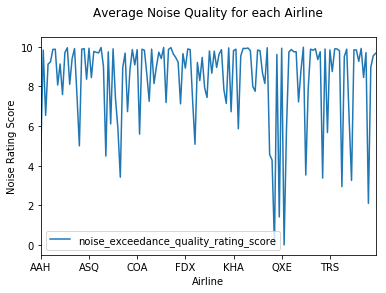

In [0]:
plt.figure()
avg_noise_airline.plot()
plt.title("Average Noise Quality for each Airline\n")
plt.ylabel("Noise Rating Score")
plt.xlabel("Airline")
plt.show()

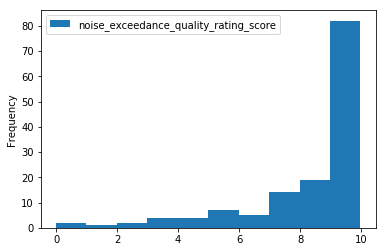

In [0]:
avg_noise_airline.plot.hist()

From the histogram above we can see a skew (right) in the data, indicating that the majority of the airlines have good noise exceedance scores where 10 is equal to not exceeding the noise limit and 0 vice versa

In [0]:
year_table = rating_table[["year","noise_exceedance_quality_rating_score"]]
per_year = year_table.groupby(["year"])
avg_noise_year = per_year.mean()

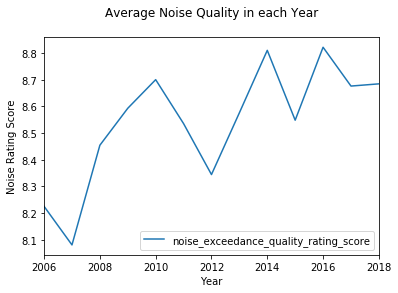

In [0]:
plt.figure()
avg_noise_year.plot()
plt.title("Average Noise Quality in each Year\n")
plt.ylabel("Noise Rating Score")
plt.xlabel("Year")
plt.show()

Another investigation carried out was looking at how the noise quality changed with each year. The graph above shows an overall improvement made by the airlines in 12 years. Additionally, we see that in 12 years the noise rating score has increased up to 0.6

In [0]:
noise_table = rating_table[["noise_exceedance_quality_rating_score","exceedances_per_1000_operations", "total_operations_per_month"]]
per_noise = noise_table.groupby(["noise_exceedance_quality_rating_score"])
avg_noise = per_noise.mean()

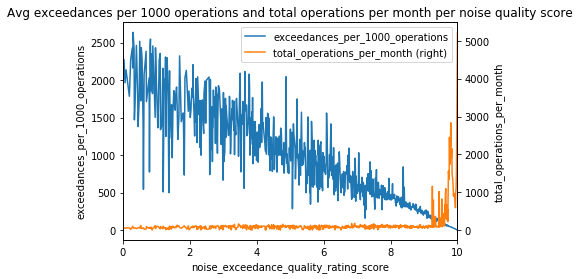

In [0]:
plt.figure()

ax = avg_noise.plot(secondary_y=["total_operations_per_month"])
ax.set_ylabel("exceedances_per_1000_operations")
ax.right_ax.set_ylabel("total_operations_per_month")

plt.title("Avg exceedances per 1000 operations and total operations per month per noise quality score")
plt.xlabel("Noise Quality Score")

plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002094BD75668>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000002094BDBE438>], dtype=object)

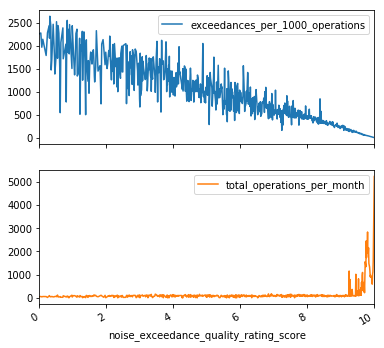

In [0]:
avg_noise.plot(subplots=True, figsize=(6, 6))

It is found that popular airlines tend to have good noise rating scores. We see that in the graph above as airlines that have more operations per month are the ones that have good score. we can imply that due to their high operations those airlines try to reduce the noise they incur on the environment.

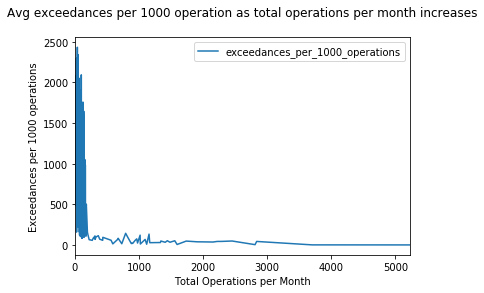

In [0]:
avg_noise_ops = avg_noise[["exceedances_per_1000_operations", "total_operations_per_month"]].groupby("total_operations_per_month")

plt.figure()
avg_noise_ops.mean().plot()
plt.title("Avg exceedances per 1000 operation as total operations per month increases\n")
plt.xlabel("Total Operations per Month")
plt.ylabel("Exceedances per 1000 operations")
plt.show()

In [0]:
#Investigate:Relationship with tot_operations and noise_quality score one.
#Investigate: Relationship with airline_operator and noise_quality score
avg_noise_exc = avg_noise[["exceedances_per_1000_operations", "total_operations_per_month"]].groupby("exceedances_per_1000_operations")

                                 total_operations_per_month
exceedances_per_1000_operations                            
5.561644                                        2810.184932


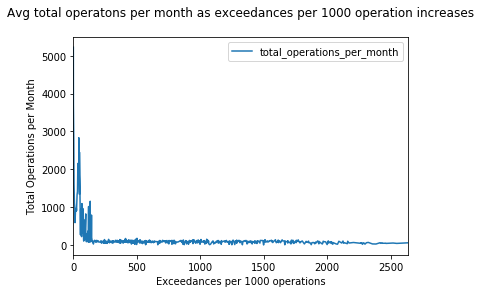

In [0]:
plt.figure()
avg_noise_exc.mean().plot()
plt.title("Avg total operatons per month as exceedances per 1000 operation increases\n")
plt.xlabel("Exceedances per 1000 operations")
plt.ylabel("Total Operations per Month")
plt.show()